In [1]:
import MDAnalysis as mda
import os
import numpy as np
from MDAnalysis import Universe
from MDAnalysis import transformations
import matplotlib.pyplot as plt
import ase.io

file1 = os.path.join('cp2k-pos-1.xyz')
# path = '/raid/hwding/cp2k/lmp-pre/6-6_lim_H-d-1.0_all-lmp-2/'
# file1 = os.path.join(path,'dump.xyz.300.pie')
# file2 = os.path.join(path,'POSCAR')
# atoms = ase.io.read(file2,format='vasp')
# atoms.write('POSCAR.cif',format='cif')

/raid/hwding/anaconda3/envs/gpumd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

u = Universe(file1)

O_atoms = u.select_atoms('type O')  # C 1, H 2, O 3
print(len(u.trajectory))


20001


In [3]:
# 设置模拟盒的维度（Å）
dim = np.array([28.136, 28.136, 14.757, 90, 90, 90])
transform = mda.transformations.boxdimensions.set_dimensions(dim)
u.trajectory.add_transformations(transform)

radius = 4.068  # Å


N_time_avg shape: (74,)


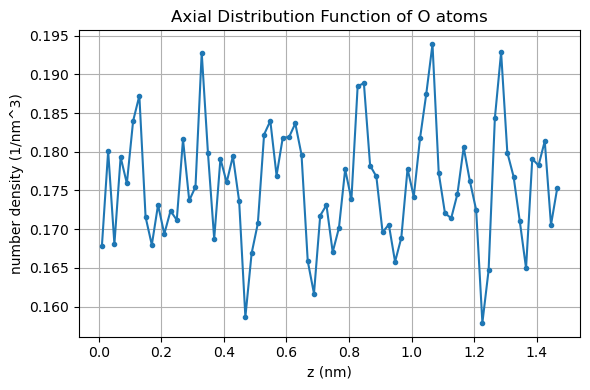

In [ ]:
def calc_volume(r: float, l: float):
    return np.pi * r**2 * l   # Å^3

# 以 0.2 Å 为 bin 宽度
nbins  = round(u.dimensions[2] / 0.2)
dz = u.dimensions[2] / nbins      # 实际 bin 宽度（Å）

area_A2 = np.pi * radius**2       # 圆截面积 Å^2
V_bin_A3 = area_A2 * dz           # 单个 bin 体积 Å^3
V_bin_nm3 = V_bin_A3 * 0.001      # 单个 bin 体积 nm^3

N_all = []        # (n_frames, nbins)

for ts in u.trajectory:   # 如果只想前 N 帧，可用 u.trajectory[0:N]
    Ni = np.zeros(nbins, dtype=float)

    O_atoms = u.select_atoms('type 3')

    for atom in O_atoms:
        z_o = atom.position[2]         # 假设也是 Å
        # 把 z_o 映射到 [0, box_z)
        # box_z = u.dimensions[2]
        # z_o = z_o % box_z               # 简单处理 PBC，可按需要调整
        bin_index = int(z_o / dz)
        if bin_index >= nbins:
            bin_index = nbins - 1
        Ni[bin_index] += 1*0.5 # 每个 O 原子计为 0.5 个，是因为pbc的原因，要除以2？

    # 转换为数密度：个 / nm^3
    # Ni = Ni / V_bin_nm3
    N_all.append(Ni.copy())

N_all = np.array(N_all)
N_time_avg = N_all.mean(axis=0)
print("N_time_avg shape:", N_time_avg.shape)

# bin 中心：Å -> nm
z_centers = (np.arange(nbins) + 0.5) * dz
z_centers_nm = z_centers / 10.0

# 画图
plt.figure(figsize=(6,4))
plt.plot(z_centers_nm, N_time_avg, '-o', markersize=3)
plt.xlabel('z (nm)')
plt.ylabel('number density (1/nm^3)')   # 或 ADF, a(z)，看你想怎么定义
plt.title('Axial Distribution Function of O atoms')
plt.grid(True)
plt.tight_layout()
plt.show()

N_time_avg shape: (74,)


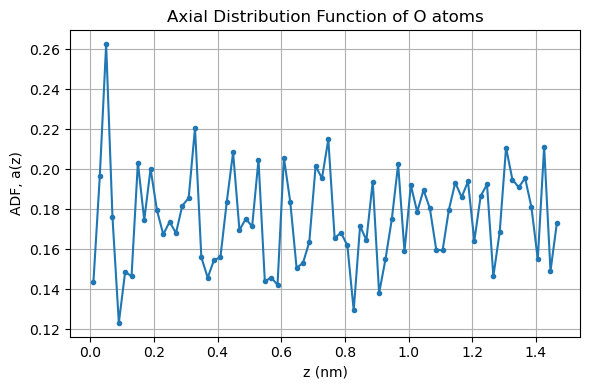

In [28]:
import MDAnalysis as mda
import os
import numpy as np
from MDAnalysis import Universe
from MDAnalysis import transformations
import matplotlib.pyplot as plt


file1 = os.path.join('cp2k-pos-1.xyz')
u = Universe(file1)

# 设置模拟盒的维度（假设单位为 Å）
dim = np.array([28.136, 28.136, 14.757, 90, 90, 90])
transform = mda.transformations.boxdimensions.set_dimensions(dim)
u.trajectory.add_transformations(transform)

radius = 4.068   # 与盒子单位一致（Å）

def calc_volume(r: float, l: float):
    """计算圆柱体体积（单位与 r, l 一致）"""
    return np.pi * r**2 * l

# 以 0.2 Å 为 bin 宽度（可按需要改成 nm）
dz = 0.2
nbins = int(round(u.dimensions[2] / dz))
dz = (u.dimensions[2]) / nbins    # 用盒长整除，保证正好覆盖整个盒子

N_all = []        # 形状最终为 (n_frames, nbins)

for ts in u.trajectory[0:]:   # 如果只想前 N 帧，可用 u.trajectory[0:N]
    Ni = np.zeros(nbins, dtype=float)
    O_atoms = u.select_atoms('name O')

    for atom in O_atoms:
        z_o = atom.position[2]         # 假设也是 Å
        # 把 z_o 映射到 [0, box_z)
        box_z = u.dimensions[2]
        z_o = z_o % box_z               # 简单处理 PBC，可按需要调整

        bin_index = int(z_o / dz)
        if bin_index >= nbins:
            bin_index = nbins - 1
        Ni[bin_index] += 1

    length = dz * nbins                 # 实际长度（≈box_z）
    volume = calc_volume(radius, length)
    # Ni = Ni                # 每个 bin 的“数密度”或 ADF 值

    N_all.append(Ni)

N_all = np.array(N_all)                 # (n_frames, nbins)
N_time_avg = N_all.mean(axis=0)        # 时间平均

# 计算 bin 中心位置（Å -> nm）
z_centers = (np.arange(nbins) + 0.5) * dz    # Å
z_centers_nm = z_centers / 10.0              # 转成 nm

print("N_time_avg shape:", N_time_avg.shape)

# 画图
plt.figure(figsize=(6, 4))
plt.plot(z_centers_nm, N_time_avg, '-o', markersize=3)
plt.xlabel('z (nm)')
plt.ylabel('ADF, a(z)')
plt.title('Axial Distribution Function of O atoms')
plt.grid(True)
plt.tight_layout()
plt.show()